# Program za izdelavo naključnih časovnih vrst valovanja 

Tukaj pipravimo različne časovne vrste valovnih potez za kasnejšo ststistično obdelavo.

In [1]:
import math as mat
import numpy as np
import random as rnd
import pandas as pd
import openpyxl

import matplotlib.pyplot as mplp
# MatPlotLib set LaTeX font
mplp.rcParams['text.usetex'] = True
mplp.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

In [2]:
# Global constants
gGa = 9.81 # gravity acceleration [m/s^2]

In [3]:
# Pierson - Moskowitz spectrum

def PM(w, Hs):
    g = 9.81
    a = 0.0081
    w0 = mat.sqrt(0.161 * gGa/Hs)
    
    S = a * g**2 * mat.pow(w,-5) * mat.exp(-1.25 * mat.pow(w/w0, -4))
    
    return S

In [4]:
# Get minimal nad maximal spectra frequency range

def get_min_max(Hs):
    w = 1e-3
    w_min = 0
    w_max = 0
    while w < 20:
        s = PM(w,Hs)
        w += 1e-3
        if (w_min == 0) and (s > 1e-4):
            w_min = w
        elif (w_min > 0) and (w_max == 0) and (s < 1e-4):
            w_max = w
            break
    
    return [w_min, w_max]

In [5]:
# Get spectra surface with Trapez integration

def get_surface(w_min,w_max,Hs):
    
    N = 100000
    dw = (w_max-w_min)/N
    S = 0
    for i in range(N):
        wi = w_min + (i+0.5)*dw
        S += PM(wi,Hs)*dw
      
    return S

In [6]:
# returns frequencies that are distant at equal surfaces

def get_surf_equidistant_freq(S,w_min,w_max,Hs,N):
    
    Ns = 10000
    si = S/N
    dw = (w_max - w_min)/Ns
    
    ss = 0
    w = []
    for i in range(Ns):
        wi = w_min + (i+0.5)*dw
        ss += PM(wi,Hs)*dw
        if ss > si:
            w.append(wi)
            ss = 0   
            
    return np.array(w)

In [7]:
# return frequencies in interval [w_min,w_max]

def get_regular_freq(S,w_min,w_max,Hs,N):
    
    w = get_surf_equidistant_freq(S,w_min,w_max,Hs,N+2)
    nw = len(w)
   
    ww = []
    for i in range(nw-1):
        dw = w[i+1] - w[i]
        wi = w[i] + 0.5*(dw)
        ww.append([wi,dw])
        
    return np.array(ww)

In [8]:
# return frequncies excluding resonant frequencies wR

def irregular_wave_amps(Hs, N, wR):
    
    [w_min, w_max] = get_min_max(Hs)
    print('W_min={:.5f}, W_max={:.5f}'.format(w_min,w_max))
    S = get_surface(w_min,w_max,Hs) # area of energy spectra
    
    # create regions of frequency to avoid resonant one
    if wR == None:
        wint = [w_min,w_max]
    else:
        wint = [w_min,wR,w_max]
    
    Np = mat.floor(N/len(wint)) + 1
    
    A = []
    dw = 1e-2 
    for i in range(len(wint)-1):
        ww = get_regular_freq(S,wint[i]+dw,wint[i+1]-dw,Hs,Np)
        for i in range(len(ww)):
            wi = ww[i,0] + rnd.random()*ww[i,1]
            si = PM(wi,Hs)
            Ai = mat.sqrt(2 * si *ww[i,1])
            A.append([wi,Ai])
        
    return np.array(A)

In [9]:
# generate irregulat wave

def generate_wave_motion(wW,aW,t,N):
    
    a = 0
    for i in range(N):
        # wave amplitude at x = 0
        a += aW[i] * mat.cos(wW[i]*t)
    
    return a

In [10]:
def write_data_to_excel(data, filename):
    
    df = pd.DataFrame(data, columns=['time [s]', 'wave amplitude [m]'])
    df.to_excel(filename, sheet_name='wave', index=False)
    
    print(df)

In [11]:
def show_wave_spectra(Hs, Nf, wRes):

    wA = irregular_wave_amps(Hs, Nf, wRes) # [freq,amp]
    N = len(wA)
    
    wW = wA[:,0]  # vector of wave frequency
    aW = wA[:,1]  # vector of wave amplitude
    lW = 2*mat.pi*gGa/wW**2 # vector of wave length
    #print('wW:\n', wW, '\naW:\n', aW, '\nlW:\n', lW)

    # PM spectral data
    pms = np.zeros(N)
    for i in range(N):
        pms[i] = PM(wW[i],Hs)
    
    fig, axs = mplp.subplots(3)
    fig.suptitle(r'Wave data - PM spectra($H_s={:.2f} \si{{m}}$)'.format(Hs))
    
    axs[0].plot(wW,pms)
    axs[0].set_xticklabels([])
    axs[0].set_ylabel(r'$S(\omega)$')
    axs[0].grid(True)

    axs[1].plot(wW,aW)
    axs[1].set_xticklabels([])
    axs[1].set_ylabel(r'$\zeta$ [m]')
    axs[1].grid(True)

    axs[2].plot(wW,lW)
    axs[2].set_xlabel(r'$\omega$ [rd/s]')
    axs[2].set_ylabel(r'$\lambda$ [m]')
    axs[2].grid(True)
    
    fig.savefig('wave_spectra.pdf')
    
    return [wW, aW, lW, N]

W_min=0.30400, W_max=6.00400


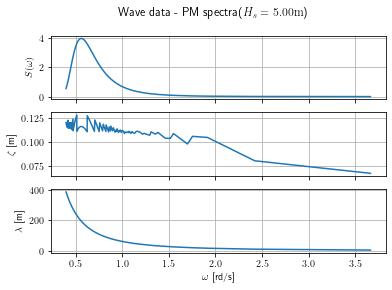

In [12]:
Hs = 5.0 # Significant wave amplitude
Nf = 500 # number of representative frequencies
wRes = None # Resonant frequency to be isolated

[wW, aW, lW, N] = show_wave_spectra(Hs, Nf, wRes)

In [13]:
data = []
dt = 3 # duration in hours 
Ts = 1000
Te = Ts + dt*3600
NT = 2*(Te - Ts)

tv = np.linspace(Ts,Te,NT)
for t in tv:
    a = generate_wave_motion(wW,aW,t,N)
    data.append([t-Ts,a])

data = np.array(data)
write_data_to_excel(data, 'wave_time_data.xlsx')

           time [s]  wave amplitude [m]
0          0.000000            0.845146
1          0.500023            0.962630
2          1.000046            0.918072
3          1.500069            0.781030
4          2.000093            0.356081
...             ...                 ...
21595  10797.999907            0.345419
21596  10798.499931            0.489200
21597  10798.999954            0.521281
21598  10799.499977            0.517768
21599  10800.000000            0.362687

[21600 rows x 2 columns]


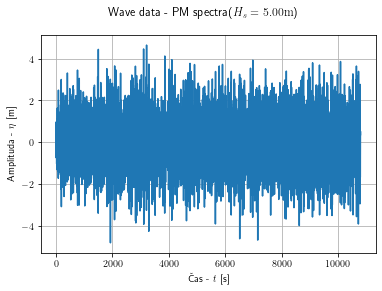

In [14]:
fig, ax = mplp.subplots()
fig.suptitle(r'Wave data - PM spectra($H_s={:.2f} \si{{m}}$)'.format(Hs))

ax.plot(data[:,0],data[:,1])
ax.set_xlabel(r'Čas - $t$ [s]')
ax.set_ylabel(r'Amplituda - $\eta$ [m]')
ax.grid(True)
fig.savefig('wave_data.pdf')